In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [140]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [141]:
N = 150 
noises = 0.15
def make_binary_clf(N, method = 'line',
                    noises = noises,
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    
    return X,y


### Синтетические данные

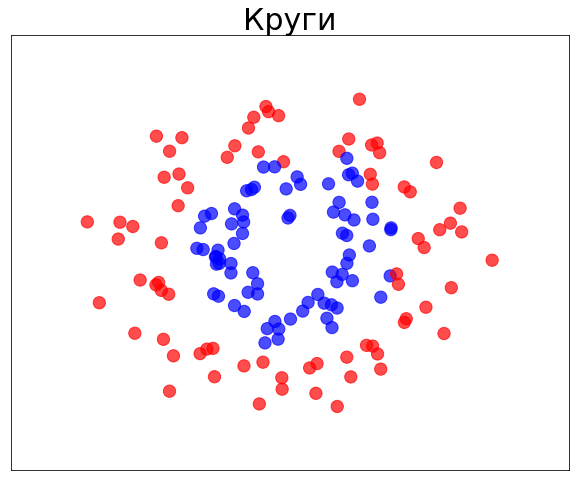

In [142]:
fig=plt.figure(figsize=(10,8))

ax = plt.subplot(1, 1, 1)
plot_data(ax, make_binary_clf(N,method = 'circles', noises = noises),
          'Круги')


In [143]:
X,y = make_binary_clf(N,method = 'circles', noises=0.05, )
X.shape

(150, 2)

#### Добавляем необходимые функции

In [144]:
def distance(X1, X2, metric = 'euclidean', p = 2):
    if metric == 'euclidean':
        dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
    if metric == 'cityblock':
        dist = np.sum(np.abs(X1 - X2).T,axis=0)
    if metric == 'Chebyshev':
        dist = np.max(np.abs(X1 - X2).T,axis=0)  
    if metric == 'Minkowski':
        dist = np.power(np.sum(np.power(np.abs(X1 - X2),p).T,axis=0),1/p)      
    return dist

In [145]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    
    fig = plt.figure(figsize=(11,10))

    plt.scatter(X[:, 0], X[:, 1], 
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'k')
    
    if old_centroids is not None:
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'k')  

    plt.xticks([])
    plt.yticks([])

In [146]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter        
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state
    #-------------------------------------    
    def distance(self,X1, X2):
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)  
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)      
        return dist
    #-------------------------------------
    def init_centroids(self, X):
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1) 
    #-------------------------------------
    def transform(self,X):
        return self.predict(X)
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        return (
                distance(self.centroids,old_centroids)/
                distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):
        
        if self.centroids is None:
            self.centroids = self.init_centroids(X)
    
        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)
            
            cluster_label = self.predict(X)

            for k in range(self.n_clusters):
                
                c_idxs = np.flatnonzero(cluster_label==k)
                
                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self        
    #-------------------------------------
    def fit_transform(self, X):
        return self.fit(X).predict(X)

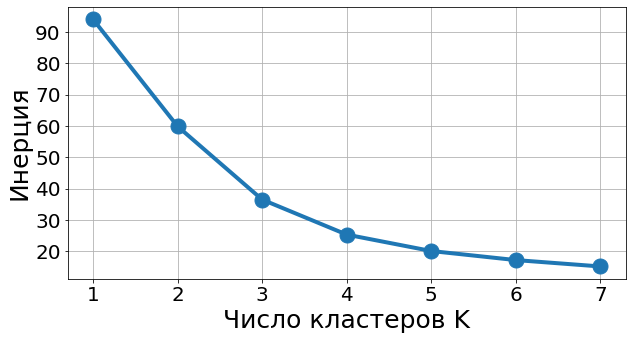

In [147]:
sse = []
list_k = list(range(1, 8))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
             linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

Посмотрим для 2 класстеров

Мы остановились на итерации:: 5


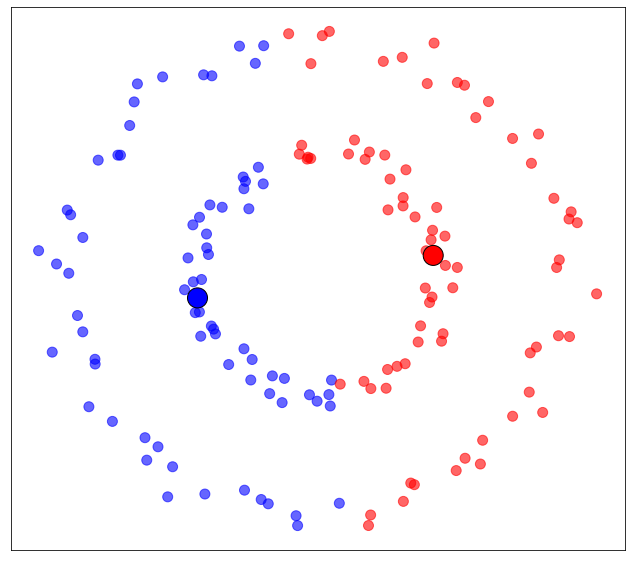

In [148]:
kmeans   = KMeans(n_clusters=2,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

Посмотрим для 4 класстеров

Мы остановились на итерации:: 5


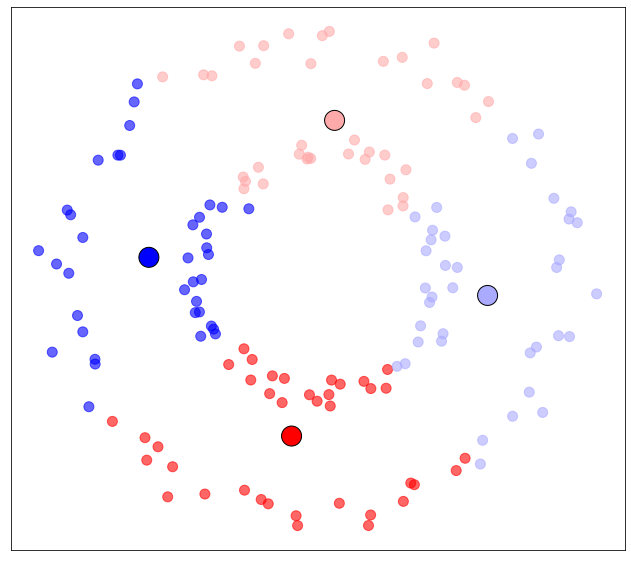

In [149]:
kmeans   = KMeans(n_clusters=4,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

#### 4. Загружаем данные MNIST

In [153]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None
    
    #--------------------------------    
    def fit(self, X):

        self.mean = np.mean(X, axis=0)
        
        # Считаем матрицу ковариации
        cov_matrix = np.cov(X - self.mean, rowvar = False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        idx = eigenvalues.argsort()[::-1] #Сортируем по возрастанию
        
        # Берём первые n главных компонент
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx]
        
        return self
    
    #--------------------------------
    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components)
    #--------------------------------
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    #--------------------------------
    def inverse_transform(self, X_new):
        return np.dot(X_new, self.components.T) + self.mean
    #--------------------------------
    def score(self, X):
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    #--------------------------------
    def plot_eigvalues(self, figsize=(15,7)):
        plt.figure(figsize=figsize)
        plt.plot(self.values,'b-o',
                 label='Все собственные значения',
                 linewidth = 3)
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное Пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(fontsize = 25); plt.yticks(fontsize = 25);
        plt.tight_layout();      

In [163]:
from sklearn.datasets import fetch_openml

In [164]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)

In [165]:
X = X / 255.
X_ = X.values

In [166]:
for i in [200, 100, 50, 25, 10]:
    pca = PCA(n_components=i)
    pca.fit(X_)
    re = pca.score(X_)
    print('Число компонент: ', i, ' ---- score: ', round(re,4))

Число компонент:  200  ---- score:  0.9763
Число компонент:  100  ---- score:  0.9399
Число компонент:  50  ---- score:  0.8765
Число компонент:  25  ---- score:  0.7829
Число компонент:  10  ---- score:  0.6388


Возьмем число компонент равное 100

In [167]:
pca = PCA(n_components=100)
X_result = pca.fit_transform(X_)

In [168]:
X_result

array([[-0.47943237, -1.24013272, -0.20051698, ..., -0.17674635,
         0.15894866, -0.4141331 ],
       [-3.96272158, -1.13711224,  2.25929704, ..., -0.2170185 ,
         0.02490066, -0.07029132],
       [ 0.23135666,  1.54391155, -0.635287  , ...,  0.1896789 ,
         0.34631557,  0.18087839],
       ...,
       [ 1.06473339,  2.31403333,  1.33870145, ...,  0.08947319,
        -0.2715233 ,  0.09572779],
       [ 1.21656793, -0.45775353,  2.4930196 , ..., -0.23002154,
        -0.06105416, -0.2043847 ],
       [-4.15240049, -0.32702956,  2.86800856, ...,  0.28274178,
         0.05178499,  0.06817856]])

#### 4.2 Применим к данным класстеризацию к-средних

Мы остановились на итерации:: 33


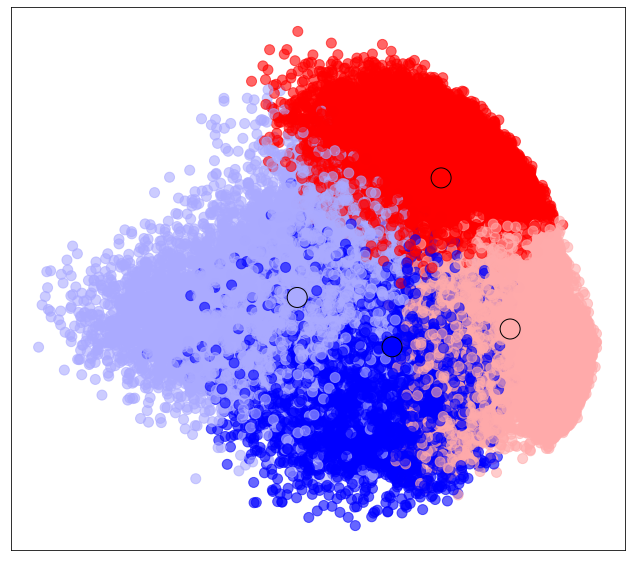

In [169]:
kmeans   = KMeans(n_clusters=4,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_result)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X_result,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

#### 4.3 Оценим число класстеров по методу Локтя

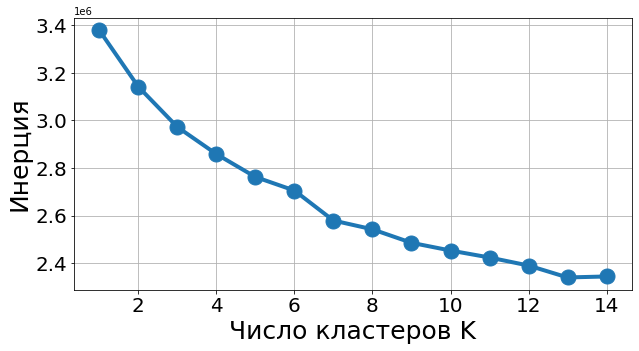

In [170]:
sse = []
list_k = list(range(1, 15))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_result)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

Мы остановились на итерации:: 15


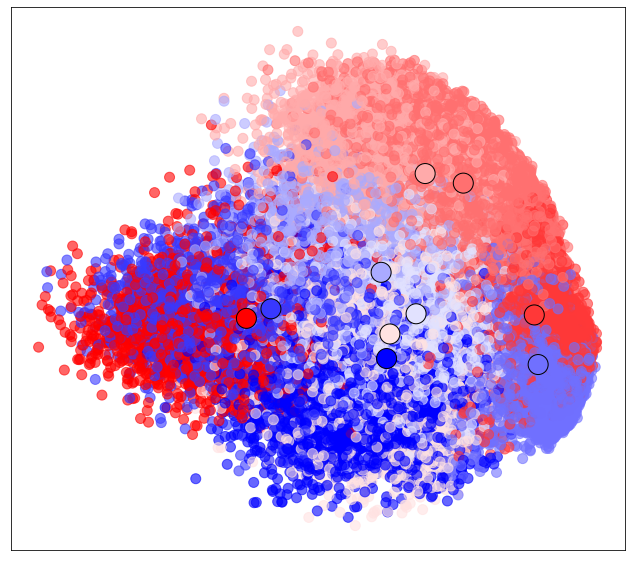

In [171]:
kmeans   = KMeans(n_clusters=10,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_result)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X_result,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

#### Оценим связь кластеров с цифрами на изображениях

In [172]:
pd.crosstab(c_labels, y)

class,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,215,8,397,4590,0,2042,33,5,1343,93
1,3065,0,116,134,11,271,144,14,38,30
2,10,3643,413,58,245,457,144,309,355,96
3,177,7,217,53,203,123,5598,5,58,13
4,177,9,175,1171,29,1851,140,12,4053,82
5,26,8,4897,293,42,24,99,57,65,13
6,35,4,184,176,3707,409,81,2123,210,3429
7,22,8,85,55,2307,447,2,4298,240,2804
8,18,4190,492,597,265,638,509,454,421,353


In [173]:
clusters = {'0':3,
           '1':0,
           '2':1,
           '3':6,
           '4':8,
           '5':2,
           '6':4,
           '7':7,
           '8':1,
           '9':0}

In [174]:
new_label = [clusters[str(i)] for i in c_labels]

Теперь номер кластера соответствует цифре на изображении

In [175]:
pd.crosstab(new_label, y)

class,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,6223,0,130,148,26,322,270,30,80,75
1,28,7833,905,655,510,1095,653,763,776,449
2,26,8,4897,293,42,24,99,57,65,13
3,215,8,397,4590,0,2042,33,5,1343,93
4,35,4,184,176,3707,409,81,2123,210,3429
6,177,7,217,53,203,123,5598,5,58,13
7,22,8,85,55,2307,447,2,4298,240,2804
8,177,9,175,1171,29,1851,140,12,4053,82


In [176]:
from sklearn.metrics import classification_report, f1_score

In [177]:
int_y = [int(i) for i in y]

Качество класстеризации по отдельным цифрам

In [179]:
print(classification_report(int_y, new_label))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      6903
           1       0.57      0.99      0.73      7877
           2       0.89      0.70      0.78      6990
           3       0.53      0.64      0.58      7141
           4       0.36      0.54      0.43      6824
           5       0.00      0.00      0.00      6313
           6       0.87      0.81      0.84      6876
           7       0.42      0.59      0.49      7293
           8       0.53      0.59      0.56      6825
           9       0.00      0.00      0.00      6958

    accuracy                           0.59     70000
   macro avg       0.50      0.58      0.53     70000
weighted avg       0.51      0.59      0.54     70000



C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Видно, что такие цифры, как 0, 1, 2, 6 имееют хорошее совпадение с класстерами, однако, цифры 5 и 9 не попадают в соответствующие класстеры

#### 5. Набор данных Cars Moldova

#### Загружаем данные

In [50]:
df = pd.read_csv("cars_moldova_cat_num (2).csv")

In [51]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

5.2 Кластеризация для набора данных Cars

In [52]:
scaler    = MinMaxScaler()
X = scaler.fit_transform(df)
pca = PCA()
X_new = pca.fit_transform(X)
X_new.shape

(32074, 11)

In [53]:
W = pca.components_
pca_names = ['pca-'+str(x+1) for x in range(W.shape[0])]

In [54]:
DF = df.copy()
DF[pca_names] = X_new 

Для удобства запишем функцию, в которой применятеся метод K-средних к нашим данным и строится график

In [100]:
def k_mean(pca_x, pca_y, k):
    
    X_cluster = DF.loc[:,['pca-'+str(pca_x), 'pca-'+str(pca_y)]].values

    km = KMeans(n_clusters=k)
    km.fit(X_cluster)
    centroids = km.cluster_centers_
    labels = km.fit_predict(X_cluster)
    label_centroids = km.fit_predict(centroids)

    plt.figure(figsize=(10, 5))
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=labels)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=490)
    return X_cluster

Рассмотрим разбиение на два класстера

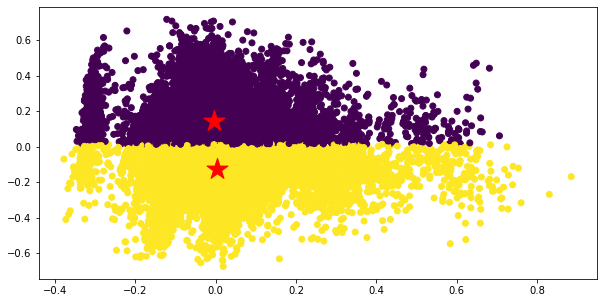

In [98]:
X_cluster = k_mean(pca_x = 3,pca_y =2, k = 2)

Воспользуемся методом Локтя для опредления оптимального числа кластеров

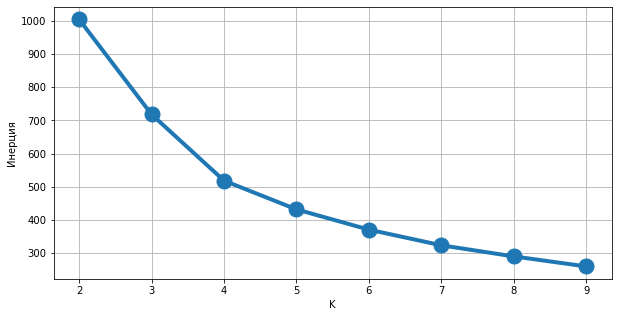

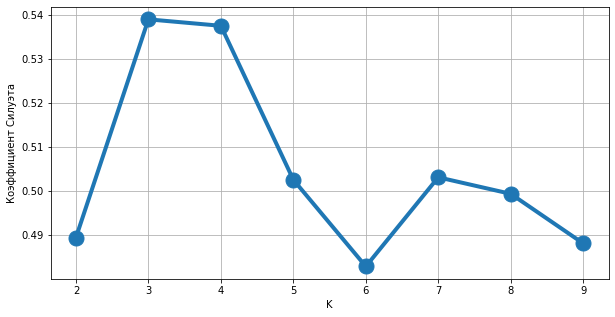

In [99]:
sse = []
sil_scor = []
list_k = list(range(2, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_cluster)
    sse.append(km.inertia_)
    labels = km.fit_predict(X_cluster)
    sil_scor.append(metrics.silhouette_score(X_cluster, labels, metric='sqeuclidean'))

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Инерция');
plt.figure(figsize=(10, 5))
plt.plot(list_k, sil_scor, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Коэффициент Силуэта');

По графику коэффициента Силуэта выбререм число класстеров равное 3

array([[-0.02282278, -0.02951853],
       [-0.02536684, -0.09560342],
       [-0.02715457, -0.08664381],
       ...,
       [-0.04807613, -0.09770108],
       [ 0.00067411,  0.01348483],
       [ 0.02448722, -0.08051552]])

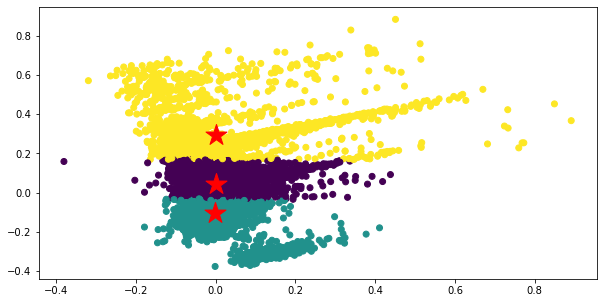

In [105]:
k_mean(pca_x = 4,pca_y =3, k = 3)

#### 5.3 Кластеризация для числовых признаков

In [106]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

#### Применим PCA к нашим данным

In [108]:
scaler    = MinMaxScaler()
X1 = scaler.fit_transform(df[num_columns])
pca = PCA(n_components=5)
X_new1 = pca.fit_transform(X1)
X_new1.shape

(32074, 5)

In [110]:
W = pca.components
pca_names = ['pca-'+str(x+1) for x in range(W.shape[0])]

In [111]:
DF = df[num_columns].copy()
DF[pca_names] = X_new1

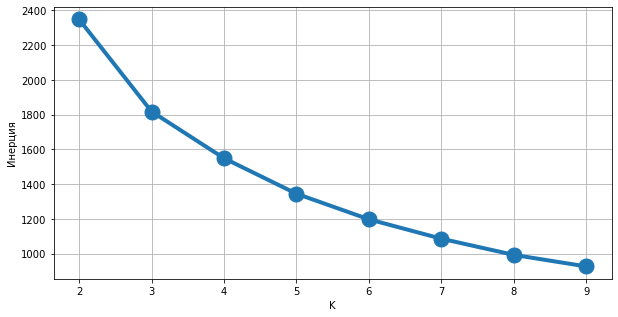

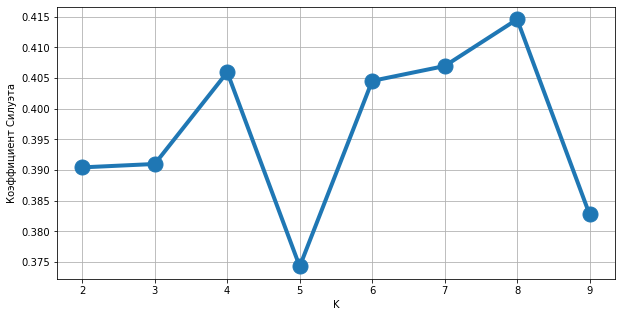

In [113]:
sse = []
sil_scor = []
list_k = list(range(2, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_new1)
    sse.append(km.inertia_)
    labels = km.fit_predict(X_new1)
    sil_scor.append(metrics.silhouette_score(X_new1, labels, metric='sqeuclidean'))

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Инерция');
plt.figure(figsize=(10, 5))
plt.plot(list_k, sil_scor, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Коэффициент Силуэта');

Согласно графику коэффициента Силуэта лучшее разиение соотвествует 8 класстерам

array([[ 0.02282278,  0.02951853],
       [ 0.02536684,  0.09560342],
       [ 0.02715457,  0.08664381],
       ...,
       [ 0.04807613,  0.09770108],
       [-0.00067411, -0.01348483],
       [-0.02448722,  0.08051552]])

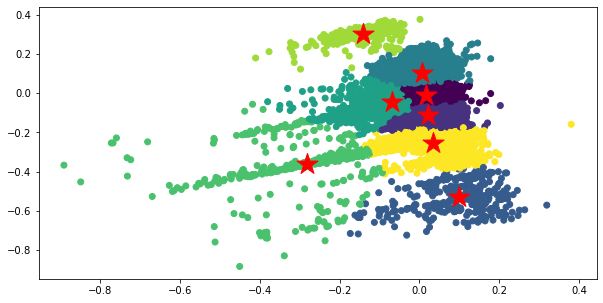

In [119]:
k_mean(pca_x = 4,pca_y =3, k = 8)

array([[ 0.01475847,  0.07275422],
       [ 0.00860714,  0.08193944],
       [ 0.03311405, -0.03921569],
       ...,
       [ 0.03102018,  0.01937005],
       [ 0.04862447,  0.12281587],
       [ 0.03893188,  0.03635033]])

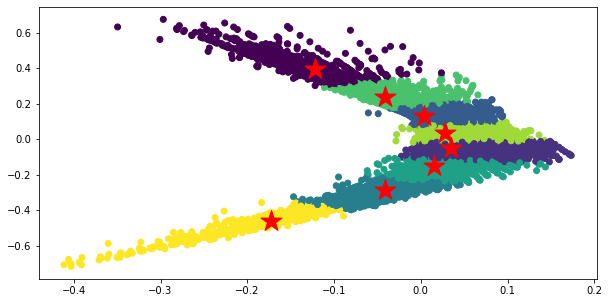

In [122]:
k_mean(pca_x = 5,pca_y =2, k = 8)

array([[ 0.07275422,  0.02355142],
       [ 0.08193944, -0.10976058],
       [-0.03921569, -0.16454761],
       ...,
       [ 0.01937005, -0.21522912],
       [ 0.12281587,  0.39950819],
       [ 0.03635033,  0.2540017 ]])

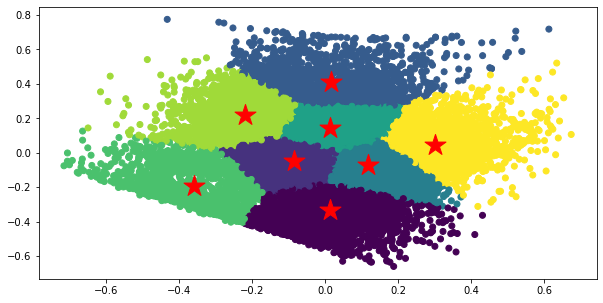

In [123]:
k_mean(pca_x = 2,pca_y =1, k = 8)

#### 5.4. Кластеризация для категориальных признаков

In [124]:
scaler    = MinMaxScaler()
X1 = scaler.fit_transform(df[cat_columns])
pca = PCA(n_components=5)
X_new1 = pca.fit_transform(X1)
X_new1.shape

(32074, 5)

In [126]:
W = pca.components
pca_names = ['pca-'+str(x+1) for x in range(W.shape[0])]
DF = df[num_columns].copy()
DF[pca_names] = X_new1

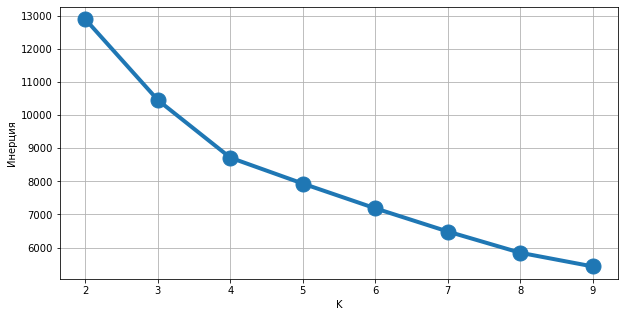

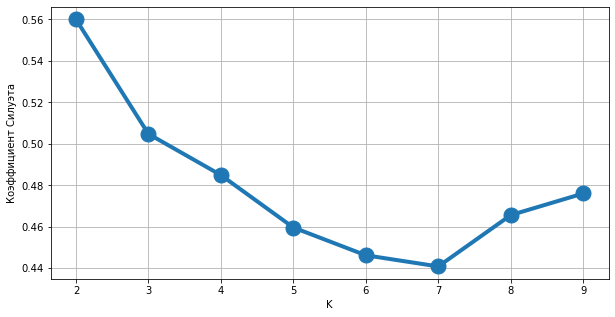

In [127]:
sse = []
sil_scor = []
list_k = list(range(2, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_new1)
    sse.append(km.inertia_)
    labels = km.fit_predict(X_new1)
    sil_scor.append(metrics.silhouette_score(X_new1, labels, metric='sqeuclidean'))

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Инерция');
plt.figure(figsize=(10, 5))
plt.plot(list_k, sil_scor, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Коэффициент Силуэта');

Согласно графику коэффициента Силуэта лучшее разиение соотвествует 2 класстерам

array([[-0.17587468, -0.03374142],
       [ 0.04071019, -0.35925265],
       [ 0.09668506, -0.36288294],
       ...,
       [ 0.32329271, -0.33207294],
       [-0.6297765 , -0.32179364],
       [-0.1692301 , -0.35740107]])

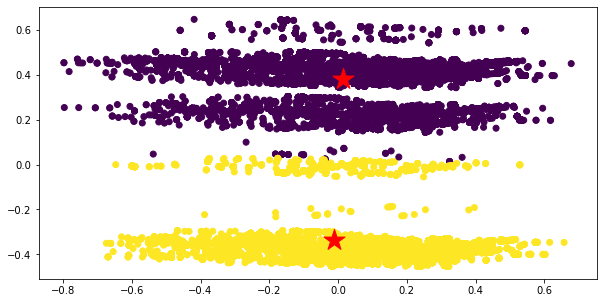

In [128]:
k_mean(pca_x = 5,pca_y =2, k = 2)

In [129]:
km_2 = KMeans(n_clusters=2)
c_labels = km_2.fit_predict(X_new1)

#### Оценим связь кластеров с категориальными признаками

С признакоми  Make, Transmission, Fuel_type

In [130]:
pd.crosstab(df["Make"], c_labels)

col_0,0,1
Make,,
0,31,7
1,528,1010
2,747,1835
3,163,158
4,32,51
5,215,80
6,1301,35
7,59,4
8,16,9


In [131]:
pd.crosstab(df["Transmission"], c_labels)

col_0,0,1
Transmission,,
0,17395,0
1,0,14679


In [132]:
pd.crosstab(df["Fuel_type"], c_labels)

col_0,0,1
Fuel_type,,
0,8821,6403
1,0,29
2,13,1823
3,2204,1259
4,6357,4727
5,0,438


#### 5.4 При применении метода к-средних также к данным применялось PCA (см. выше)

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [134]:
def rs(x,y):
    model = LogisticRegression()
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state = 42)
    model.fit(x_train, y_train)
    pred=model.predict(x_test)
    print(classification_report(y_test,pred))

In [135]:
y = df["Transmission"]

С применением PCA только к числовым признакам

In [136]:
rs(X_new1,y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3525
           1       1.00      1.00      1.00      2890

    accuracy                           1.00      6415
   macro avg       1.00      1.00      1.00      6415
weighted avg       1.00      1.00      1.00      6415



С применением PCA к числовым и категориальным признакам

In [137]:
rs(X_new,y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3525
           1       1.00      1.00      1.00      2890

    accuracy                           1.00      6415
   macro avg       1.00      1.00      1.00      6415
weighted avg       1.00      1.00      1.00      6415



Без использования PCA

In [138]:
rs(df,y)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      3525
           1       0.83      0.74      0.78      2890

    accuracy                           0.81      6415
   macro avg       0.82      0.81      0.81      6415
weighted avg       0.82      0.81      0.81      6415

